In [ ]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input,UpSampling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers
import cv2
from tqdm import tqdm
import random
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from sklearn.cluster import KMeans
import tensorflow.compat.v1 as tf

from keras.utils.vis_utils import plot_model
from IPython.display import Image
from keras import backend as K

In [ ]:
jobs = 4 # number of cores
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                     inter_op_parallelism_threads=jobs,
                     allow_soft_placement=True,
                     device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

In [ ]:
def preprocess_img(img_path):
    dsize = (img_width, img_height)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize)
    new_image=np.expand_dims(new_image,axis=0)
    new_image=np.flip(new_image,axis=-1)
    return new_image

In [ ]:
class DenoiseDataGenerator(Sequence):    
    def __init__(self, x_set, batch_size, width, height):
        self.x = x_set
        self.batch_size = batch_size
        self.width  = width
        self.height = height
        self.idx = 0
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = np.array([resize(imread(file_name), (self.width, self.height)) for file_name in batch_x])

        

        return np.array([add_noise(img) for img in batch_y.copy()]), np.array(batch_y)

In [ ]:
def apk(actual, predicted, k=10):

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):

    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [ ]:
img_width, img_height = (256, 256)
BATCH_SIZE = 4

In [ ]:
path='./dataset'

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 100
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
# full_paths = ['C:/Users/Rod/Desktop/Tarea 3/dataset/database-full/' + x for x in os.listdir('./dataset/database-full/')]

In [ ]:
# noise_img = DenoiseDataGenerator(full_paths, BATCH_SIZE, img_width, img_height)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
img_data=datagen.flow_from_directory(path, target_size=(img_width, img_height), class_mode='input', batch_size=BATCH_SIZE,shuffle=False)

Found 31783 images belonging to 1 classes.


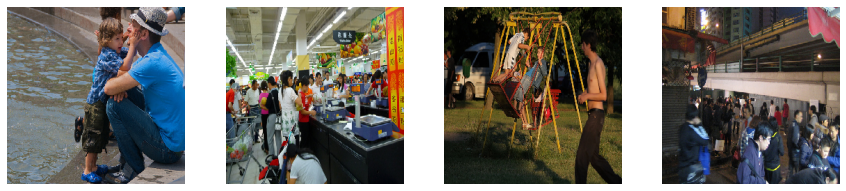

In [ ]:
plt.figure(figsize=(15,15))
for images in img_data.next():
    for i in range(4):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(images[i])
        ax.axis("off")

# Auto Encoder RGB

In [ ]:
batch_size = 8
pretrain_optimizer = tf.keras.optimizers.Adam()
pretrain_epochs = 1
batch_size = batch_size

In [ ]:
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# LATENT SPACE
latentSize = (16*16*8)

input_img = keras.Input(shape=(img_width, img_height, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Flatten()(x)
#encoded = layers.Dense(units=latentSize, activation='sigmoid')(x)

# DECODER
direct_input = keras.Input(shape=latentSize)
#x = layers.Dense(units=latentSize, activation='sigmoid')(direct_input)
x = layers.Reshape((16, 16, 8))(direct_input)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (2, 2), activation='sigmoid', padding='same')(x)

encoder = keras.Model(input_img, encoded)
decoder = keras.Model(direct_input,decoded)
autoencoder = keras.Model(input_img, decoder(encoded))
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624

In [ ]:
class ClusteringLayer(Layer):    
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)    
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True    
    
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        
        return q
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters    
    
    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
n_clusters = 10

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
#Image(filename='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
autoencoder.fit(img_data, batch_size=batch_size, epochs=pretrain_epochs)

7946/7946 [==============================] - 4523s 569ms/step - loss: 0.0184 - accuracy: 0.6796


In [ ]:
autoencoder.save("autoencoder.h5")
encoder.save("encoder.h5")
decoder.save("decoder.h5")

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 10 
update_interval = 1 
tol = 0.001 # tolerance threshold to stop training


kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(img_data, verbose=1))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

cl_model =  Model(model.get_layer(name='clustering').input, model.get_layer(name='clustering').output )

index_array = [x for x in range(31783)]

for ite in range(int(maxiter)):
    print(f"Starting iter {ite} of {maxiter} iterations")
    if ite % update_interval == 0:
        #q, _  = model.predict(img_data, verbose=0, batch_size=BATCH_SIZE)
        q = cl_model.predict(encoder.predict(img_data, verbose=1), verbose=0, batch_size=BATCH_SIZE) 
        p = target_distribution(q)  
        y_pred = q.argmax(1)        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, 31783)]
    lote = np.array([img_data.__getitem__(id_)[0][0] for id_ in idx])
    loss = model.train_on_batch(x=lote, y=[p[idx], lote])
    index = index + 1 if (index + 1) * batch_size <= 31783 else 0

7946/7946 [==============================] - 481s 61ms/step
Starting iter 0 of 10 iterations
7946/7946 [==============================] - 489s 62ms/step
Starting iter 1 of 10 iterations
7946/7946 [==============================] - 491s 62ms/step
Starting iter 2 of 10 iterations
7946/7946 [==============================] - 490s 62ms/step
Starting iter 3 of 10 iterations
7946/7946 [==============================] - 494s 62ms/step
Starting iter 4 of 10 iterations
7946/7946 [==============================] - 501s 63ms/step
Starting iter 5 of 10 iterations
7946/7946 [==============================] - 498s 63ms/step
Starting iter 6 of 10 iterations
7946/7946 [==============================] - 494s 62ms/step
Starting iter 7 of 10 iterations
7946/7946 [==============================] - 499s 63ms/step
Starting iter 8 of 10 iterations
7946/7946 [==============================] - 493s 62ms/step
Starting iter 9 of 10 iterations
7946/7946 [==============================] - 495s 62ms/step


In [ ]:
autoencoder.save("post_autoencoder.h5")
encoder.save("post_encoder.h5")
decoder.save("post_decoder.h5")

In [ ]:
cl_model.save("clustering.h5")

In [ ]:
latents = encoder.predict(img_data, verbose=1)

7946/7946 [==============================] - 495s 62ms/step


In [ ]:
q_ = cl_model.predict(latents)
p_ = target_distribution(q_)
y_pred = p_.argmax(1)

994/994 [==============================] - 2s 2ms/step


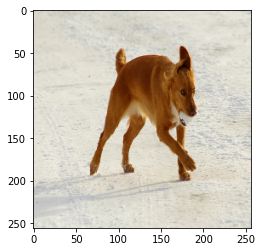

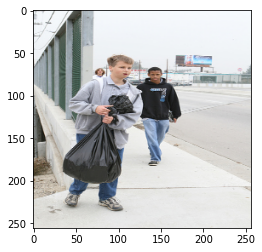

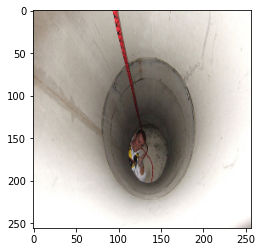

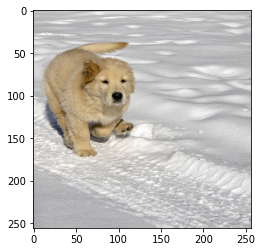

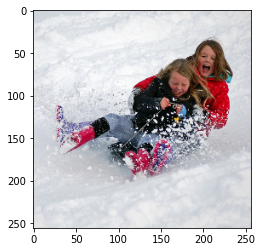

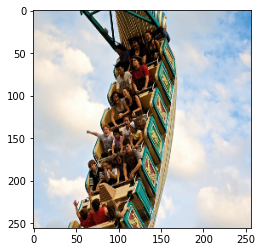

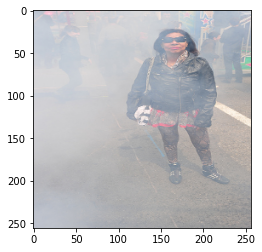

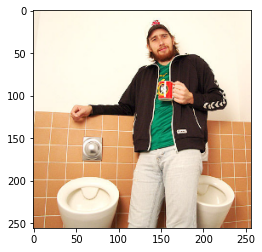

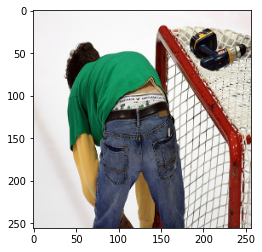

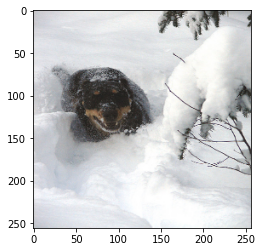

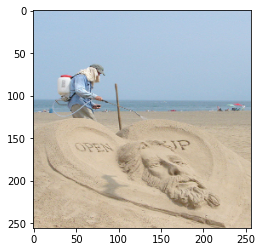

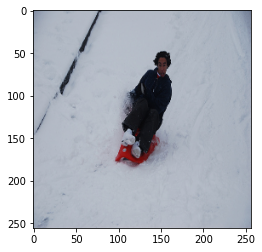

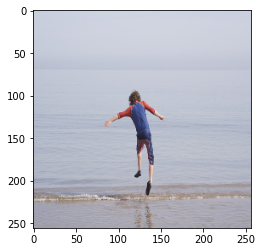

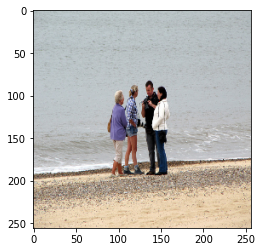

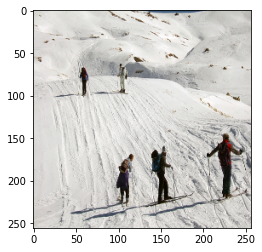

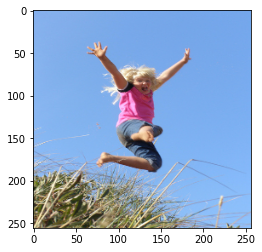

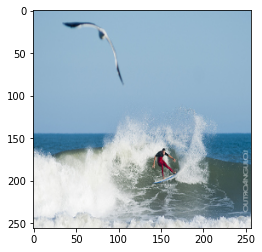

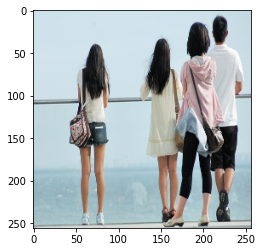

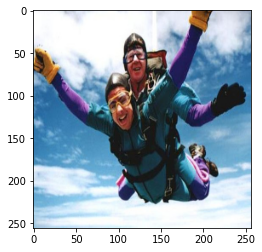

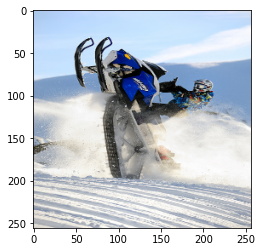

In [ ]:
for x in np.array(img_data.filepaths)[y_pred == 1][:20]:
    plt.imshow(preprocess_img(x)[0])
    plt.show()

In [ ]:
indices = [x[34:-4] for x in img_data.filenames]
encoded_df = pd.DataFrame({'img_name':indices, 'encoded':[x.flatten() for x in latents]})

In [ ]:
def sorting(tup, reverse=True):
    return(sorted(tup, key = lambda x: x[1],reverse=reverse))

In [ ]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import cosine
def get_most_similars(query, database):
    
    x2 = database[database.img_name == query].encoded.values[0]
    
    distances = []
    names = []
    for i, fila in database.iterrows():

        x1 = fila.encoded
        names.append(fila.img_name)
        distances.append(np.linalg.norm(x1 - x2))
        
    distances = [(x,y) for x,y in zip(names, distances)]
    distances = sorting(distances, False)
        
    return np.array(distances)[:,0]

In [ ]:
encoded_df['cluster'] = y_pred

In [ ]:
encoded_df.head(5)

img_name                                            encoded  cluster
0        0  [0.68270254, 0.97293293, 1.1087692, 1.1661555,...        5
1        1  [0.8171463, 0.88260216, 0.93343973, 1.0892751,...        5
2       10  [1.2302302, 1.7080035, 1.5640966, 1.838297, 0....        5
3      100  [1.4711636, 1.0454937, 0.9554608, 1.6045191, 1...        5
4     1000  [0.67135656, 0.65541106, 0.28343707, 0.7934792...        0

In [ ]:
i = '46'

cluster = encoded_df[encoded_df.img_name == i].cluster.values[0]
most_sim=get_most_similars(i, encoded_df[encoded_df.cluster == cluster])

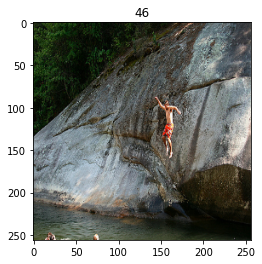

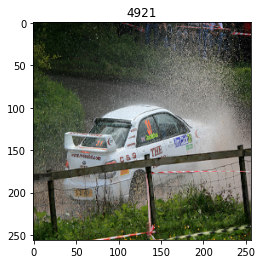

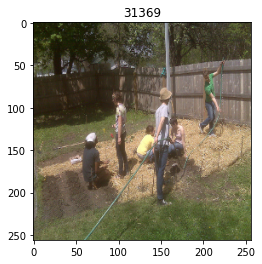

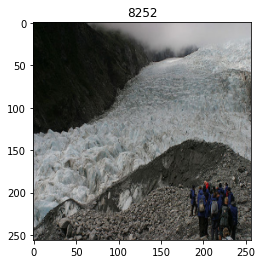

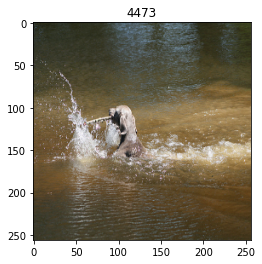

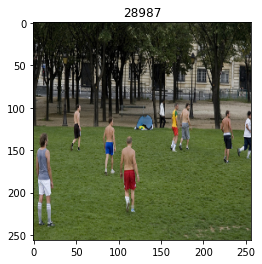

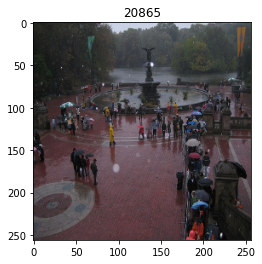

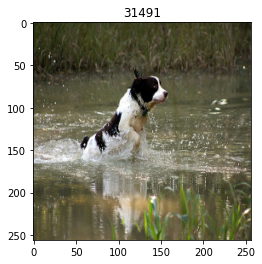

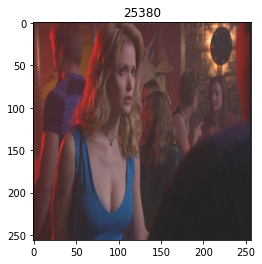

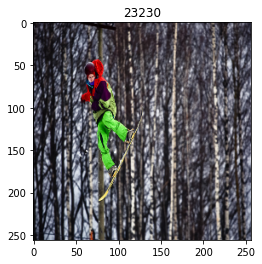

In [ ]:
for im in most_sim[:10]:
    plt.imshow(preprocess_img('dataset/database-full/database-full/ image' + im+".jpg")[0])
    plt.title(im)
    plt.show()